In [1]:
"""Test the package of orthogonal polynomials using aribitary measure. Link: https://github.com/j-jith/orthopoly#id1"""
import torch
import numpy as np
import numpy.polynomial.polynomial as nppoly
from ortho2sig import OrthoPoly, Sig2path
import signatory
import matplotlib.pyplot as plt
from main_funcs import random_trig_generator
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import time

e:\File_VSCode\M3R\m3r_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Orthogonal polynomials

In [2]:
# Legendre polynomial
pdf_l = lambda z: 1.0
intlims = [-1, 1]
order = 10
pp = OrthoPoly(pdf_l, intlims=intlims)
pp.gen_poly(order)

pp.poly

[array([0.70710678]),
 array([0.        , 1.22474487]),
 array([-0.79056942,  0.        ,  2.37170825]),
 array([ 0.        , -2.80624304,  0.        ,  4.67707173]),
 array([ 0.79549513,  0.        , -7.95495129,  0.        ,  9.2807765 ]),
 array([  0.        ,   4.39726477,   0.        , -20.52056895,
          0.        ,  18.46851205]),
 array([ -0.7967218 ,   0.        ,  16.73115778,   0.        ,
        -50.19347334,   0.        ,  36.80854711]),
 array([   0.        ,   -5.99071547,    0.        ,   53.91643925,
           0.        , -118.61616636,    0.        ,   73.42905537]),
 array([   0.79720045,    0.        ,  -28.69921636,    0.        ,
         157.84568997,    0.        , -273.59919594,    0.        ,
         146.57099783]),
 array([   0.        ,    7.58511879,    0.        , -111.24840896,
           0.        ,  433.86879494,    0.        , -619.8125642 ,
           0.        ,  292.68926643]),
 array([-7.97434891e-01,  0.00000000e+00,  4.38589190e+01,  0.000

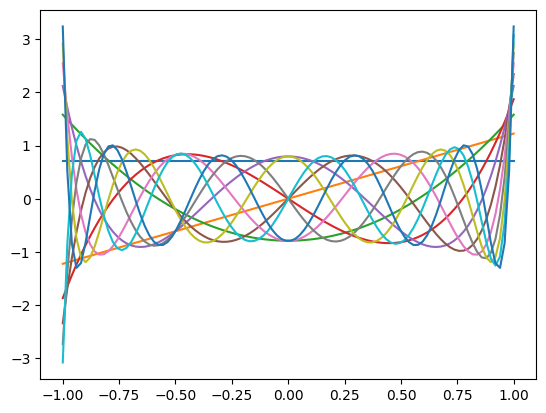

In [3]:
xx = np.linspace(-1, 1, 100)
for p_i in pp.poly:
    plt.plot(xx, nppoly.polyval(xx, p_i))
plt.show()

In [4]:
# test coefficients of orthogonal polynomials
coeff_order = 15
t_grid = np.linspace(-1, 1, 200)
example_path = lambda t: np.cos(15*t) - np.sin(3*t) - (np.cos(-15) - np.sin(-3))
print(pp.a(example_path, coeff_order)-pp.a(example_path(t_grid), coeff_order))

[ 1.16157978e-04 -5.83264050e-05  2.71071113e-04 -6.68644536e-05
  3.99098428e-04 -3.36237049e-05  5.46328473e-04  4.54781760e-05
  7.28196057e-04  1.76014279e-04  9.53955123e-04  3.63413967e-04
  1.23005433e-03  6.12680880e-04  1.56109474e-03  9.28267759e-04]


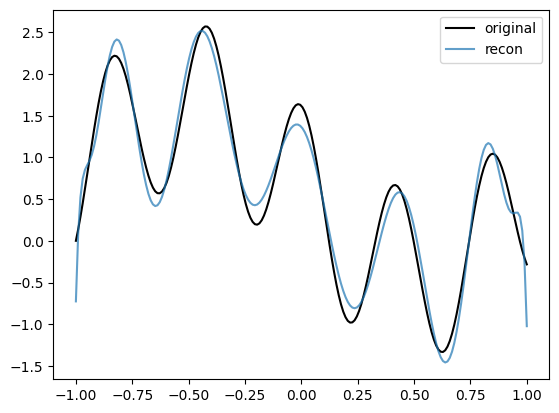

In [5]:
plt.plot(t_grid, example_path(t_grid), color='black', label='original')
plt.plot(t_grid, pp.path_eval(t_grid, example_path(t_grid), coeff_order), label='recon', alpha=0.7)
plt.legend()

In [6]:
# scaled Hermite polynomial
pdf_h = lambda z: np.exp(-z**2/2/0.05)
intlims = [-1, 1]
order = 10
pp = OrthoPoly(pdf_h, intlims=intlims)
pp.gen_poly(order)

pp.poly

[array([1.33571626]),
 array([0.        , 5.97398863]),
 array([-0.94514521,  0.        , 18.90596697]),
 array([ 0.        , -7.34650596,  0.        , 49.02966688]),
 array([  0.82867653,   0.        , -33.2804813 ,   0.        ,
        111.48218939]),
 array([   0.        ,    8.49788585,    0.        , -114.80157988,
           0.        ,  233.3603546 ]),
 array([  -0.79416586,    0.        ,   48.94191812,    0.        ,
        -337.14035184,    0.        ,  468.13901774]),
 array([   0.        ,   -9.94559612,    0.        ,  209.91302497,
           0.        , -896.57821377,    0.        ,  925.58713208]),
 array([ 7.93622660e-01,  0.00000000e+00, -6.85590568e+01,  0.00000000e+00,
         7.51658135e+02,  0.00000000e+00, -2.23928757e+03,  0.00000000e+00,
         1.82878488e+03]),
 array([    0.        ,    11.55082216,     0.        ,  -346.48795804,
            0.        ,  2389.40296973,     0.        , -5367.27060694,
            0.        ,  3625.00016211]),
 array([-7.

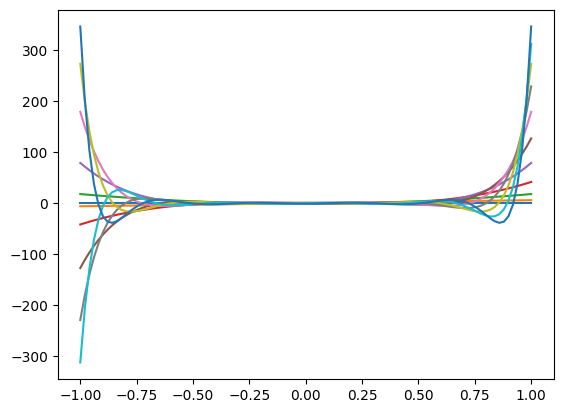

In [7]:
xx = np.linspace(-1, 1, 100)
for p_i in pp.poly:
    plt.plot(xx, nppoly.polyval(xx, p_i))
plt.show()

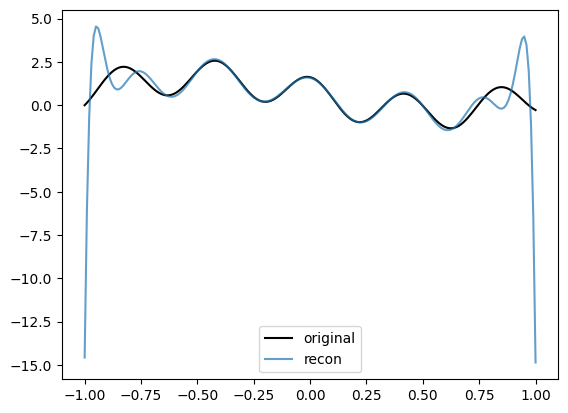

In [8]:
plt.plot(t_grid, example_path(t_grid), color='black', label='original')
plt.plot(t_grid, pp.path_eval(t_grid, example_path(t_grid), coeff_order), label='recon', alpha=0.7)
plt.legend()

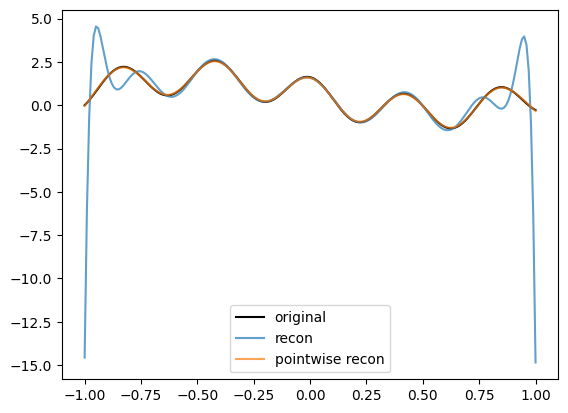

In [9]:
# pointwise reconstruction
def pdf_hermite(t, params):
    t0, eps = params
    return np.exp(-(t-t0)**2/2/eps**2) / eps

pointwise_order = 3
pointwise_poly = np.zeros_like(t_grid)

for i, t in enumerate(t_grid):
    hermite = OrthoPoly(pdf_hermite, margs=[t, 0.05])
    pointwise_poly[i] = hermite.path_eval(t, example_path, pointwise_order)

plt.plot(t_grid, example_path(t_grid), color='black', label='original')
plt.plot(t_grid, pp.path_eval(t_grid, example_path, coeff_order), label='recon', alpha=0.7)
plt.plot(t_grid, pointwise_poly, label='pointwise recon', alpha=0.7)
plt.legend()

### Signatures

In [10]:
length = 200
t_grid = np.linspace(-1, 1, length)
N = 15

# inversion via legendre
inv1 = Sig2path(pdf_l, t_grid=t_grid)
rec = inv1.path2path(t_grid, example_path(t_grid), N)

In [11]:
a_arr = inv1.poly_class.a(example_path, N)
a_sig = inv1._a_sig(inv1.sig(example_path(t_grid), N), N)
print(a_arr-a_sig)

[ 1.16157978e-04 -6.41456522e-05  1.95683175e-04  4.30941542e-05
  2.12432264e-05 -5.83032891e-06 -4.41150825e-04  3.38806032e-07
 -7.94268633e-04 -1.28650471e-08 -2.18008306e-05  1.03095554e-08
  1.16781017e-03  3.28831437e-07 -1.00429403e-03  5.81331551e-06]


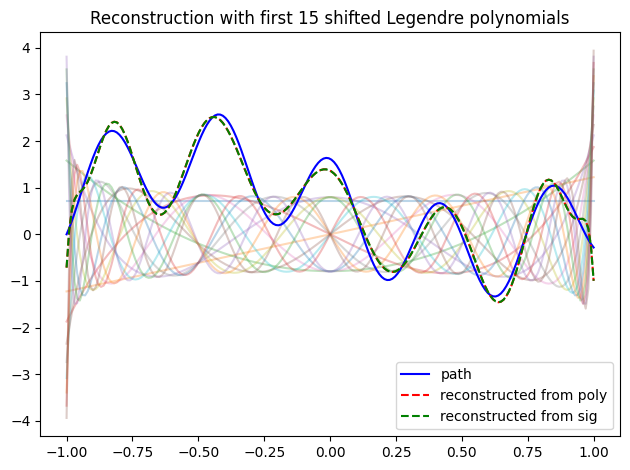

In [12]:
for p_i in inv1.poly_class.poly:
    plt.plot(t_grid, nppoly.polyval(t_grid, p_i), alpha=0.3)
plt.plot(t_grid, example_path(t_grid), label='path', c='blue')
plt.plot(t_grid, inv1.poly_class.path_eval(t_grid, example_path, N), label='reconstructed from poly', c='red', linestyle='--')
plt.plot(t_grid, rec, label='reconstructed from sig', c='g', linestyle='--')
plt.legend()
plt.title(f'Reconstruction with first {N} shifted Legendre polynomials')
plt.tight_layout()

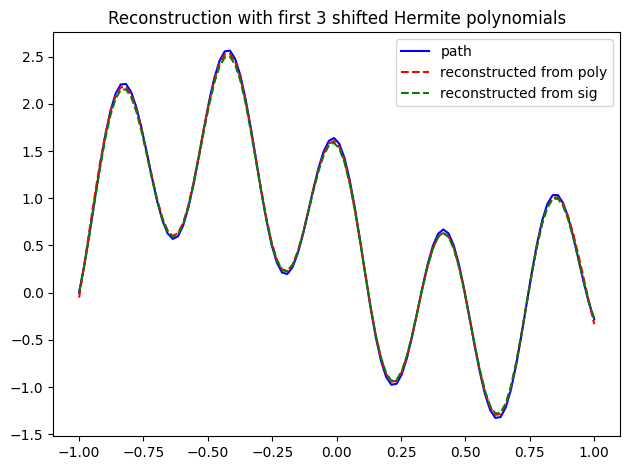

In [13]:
# inversion via Hermite
pointwise_order = 3
t_grid = np.linspace(-1, 1, 100)

pointwise_poly = np.zeros_like(t_grid)
pointwise_sig = np.zeros_like(t_grid)
for i, t in enumerate(t_grid):
    inv2 = Sig2path(pdf_hermite, margs=[t, 0.05])
    pointwise_poly[i] = inv2.poly_class.path_eval(t, example_path, pointwise_order)
    pointwise_sig[i] = inv2.path2path(t, example_path(t_grid), pointwise_order)
    # a_arr = inv2.poly_class.a(example_path, pointwise_order)
    # a_sig = np.array([inv2._a_sig(inv2.sig(example_path(t_grid), pointwise_order), n) for n in range(pointwise_order)])
    # print(a_arr-a_sig)

plt.plot(t_grid, example_path(t_grid), label='path', c='blue')
plt.plot(t_grid, pointwise_poly, label='reconstructed from poly', c='red', linestyle='--')
plt.plot(t_grid, pointwise_sig, label='reconstructed from sig', c='g', linestyle='--')
plt.legend()
plt.title(f'Reconstruction with first {pointwise_order} shifted Hermite polynomials')
plt.tight_layout()

### Compare with insertion method
#### 2d cases

In [14]:
## Insertion
# Create a path consisting in a half circle
t_grid = torch.linspace(0, 1, 10)
path = torch.stack([torch.cos(np.pi * t_grid), torch.sin(np.pi * t_grid)]).T.unsqueeze(0)

# Compute the signature
depth = 6
signature = signatory.signature(path, depth)

# Reconstruct the path by inverting the signature
reconstructed_signatory = signatory.invert_signature(signature, depth, path.shape[2], initial_position=path[:, 0, :])
path.shape

torch.Size([1, 10, 2])

In [15]:
# inversion via legendre
inv1 = Sig2path(pdf_l, t_grid=np.array(t_grid))
rec1 = np.zeros((len(t_grid), 2))
rec1[:, 0] = inv1.path2path(np.array(t_grid), np.array(path)[0, :, 0], depth-2) + np.array(path)[0, 0, 0]
rec1[:, 1] = inv1.path2path(np.array(t_grid), np.array(path)[0, :, 1], depth-2) + np.array(path)[0, 0, 1]

In [16]:
# suitable for multi-dimensional path
inv2 = Sig2path(pdf_l, t_grid=np.array(t_grid))
rec2 = inv2.path2path(np.array(t_grid), np.array(path)[0], depth-2, dim=2) + np.array(path)[0, 0, :]

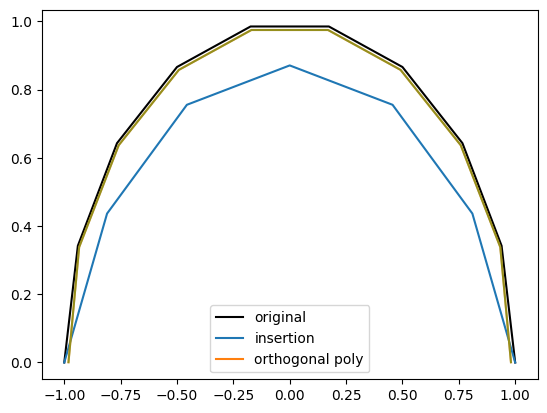

In [17]:
plt.plot(path[0, :, 0], path[0, :, 1], color='black', label='original')
plt.plot(reconstructed_signatory[0, :, 0], reconstructed_signatory[0, :, 1], label='insertion')
plt.plot(rec1[:, 0], rec1[:, 1], label='orthogonal poly')
plt.plot(rec2[:, 0], rec2[:, 1], alpha=0.5)
plt.legend()

 90%|█████████ | 9/10 [02:07<00:34, 34.34s/it]e:\File_VSCode\M3R\M3R_LMU\ortho2sig.py:53: RuntimeWarning: invalid value encountered in sqrt
  self.poly[i] = self.poly[i] / np.prod(np.sqrt(beta[:i+1]))
e:\File_VSCode\M3R\M3R_LMU\ortho2sig.py:53: RuntimeWarning: invalid value encountered in sqrt
  self.poly[i] = self.poly[i] / np.prod(np.sqrt(beta[:i+1]))
e:\File_VSCode\M3R\M3R_LMU\ortho2sig.py:53: RuntimeWarning: invalid value encountered in sqrt
  self.poly[i] = self.poly[i] / np.prod(np.sqrt(beta[:i+1]))
e:\File_VSCode\M3R\M3R_LMU\ortho2sig.py:53: RuntimeWarning: invalid value encountered in sqrt
  self.poly[i] = self.poly[i] / np.prod(np.sqrt(beta[:i+1]))
e:\File_VSCode\M3R\M3R_LMU\ortho2sig.py:53: RuntimeWarning: invalid value encountered in sqrt
  self.poly[i] = self.poly[i] / np.prod(np.sqrt(beta[:i+1]))
e:\File_VSCode\M3R\M3R_LMU\ortho2sig.py:53: RuntimeWarning: invalid value encountered in sqrt
  self.poly[i] = self.poly[i] / np.prod(np.sqrt(beta[:i+1]))
e:\File_VSCode\M3R\M3R_L

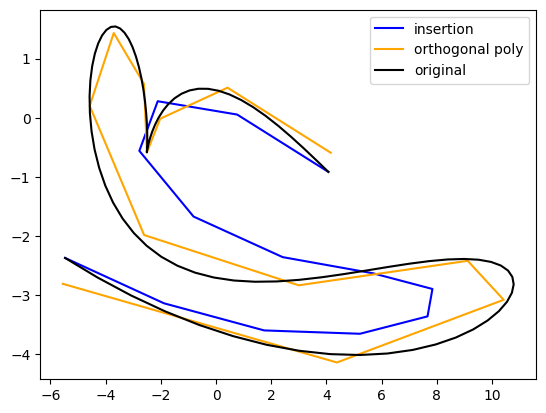

In [21]:
sample_num = 10
max_depth = 12
t_grid = np.linspace(0, 1, 100)

errors = np.zeros((2, max_depth-2))
time_cost = np.zeros((2, max_depth-2))

func_list = []
for _ in range(sample_num):
    func_list.append([random_trig_generator(np.random.randint(1, 10000)), random_trig_generator(np.random.randint(1, 10000))])

for depth in tqdm(range(3, max_depth+1)):
    t = np.linspace(0, 1, depth+1)
    for i in range(sample_num):
        func1, func2 = func_list[i]
        path = np.c_[func1(t_grid), func2(t_grid)]
        path_torch = torch.tensor(path).unsqueeze(0)
        # insertion
        signature = signatory.signature(path_torch, depth)
        start = time.time()
        recon_insertion = signatory.invert_signature(signature, depth, path_torch.shape[2], initial_position=path_torch[:, 0, :])
        end = time.time()
        errors[0, depth-3] += mean_squared_error(np.c_[func1(t), func2(t)], np.array(recon_insertion.squeeze(0)))
        time_cost[0, depth-3] += end - start
        # inversion via Legendre polynomials
        inv1 = Sig2path(pdf_l, t_grid=t_grid, depth=depth)
        sig = inv1.sig(path, depth)
        start = time.time()
        rec = inv1.sig2path(t, depth-2, sig=sig, dim=2) + path[0]
        end = time.time()
        errors[1, depth-3] += mean_squared_error(np.c_[func1(t), func2(t)], rec)
        time_cost[1, depth-3] += end - start

errors /= sample_num
time_cost /= sample_num

# # visualsation
plt.plot(np.array(recon_insertion.squeeze(0))[:, 0], np.array(recon_insertion.squeeze(0))[:, 1], color='blue', label='insertion')
plt.plot(rec[:, 0], rec[:, 1], color='orange', label='orthogonal poly')
plt.plot(path[:, 0], path[:, 1], color='black', label='original')
plt.legend()

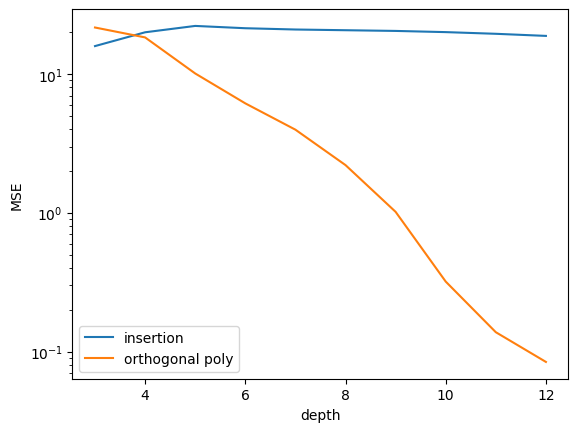

In [22]:
plt.plot(range(3, max_depth+1), errors[0], label='insertion')
plt.plot(range(3, max_depth+1), errors[1], label='orthogonal poly')
plt.xlabel('depth')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()

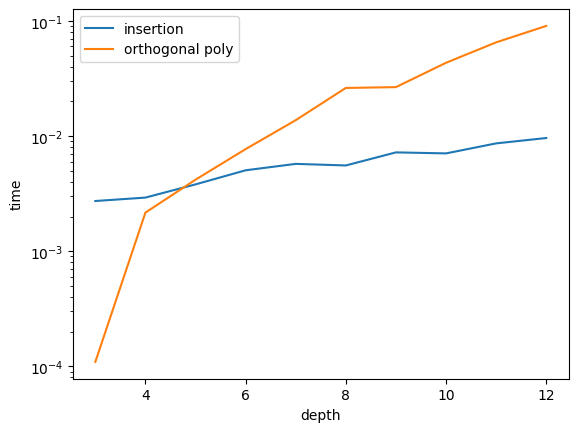

In [23]:
plt.plot(range(3, max_depth+1), time_cost[0], label='insertion')
plt.plot(range(3, max_depth+1), time_cost[1], label='orthogonal poly')
plt.xlabel('depth')
plt.ylabel('time')
plt.yscale('log')
plt.legend()

#### 1d cases

In [24]:
# Create a path consisting in a half circle
t_grid = torch.linspace(0, 1, 50)
path = example_path(t_grid).T.unsqueeze(0).unsqueeze(2)

# Compute the signature
depth = 8
signature = signatory.signature(path, depth)

# Reconstruct the path by inverting the signature
reconstructed_signatory = signatory.invert_signature(signature, depth, path.shape[2], initial_position=path[:, 0, :])
path.shape

torch.Size([1, 50, 1])

In [25]:
# inversion via legendre
inv1 = Sig2path(pdf_l, t_grid=np.array(t_grid))
rec = inv1.path2path(np.array(t_grid), np.array(path)[0, :, 0], depth-2) + np.array(path)[0, 0, 0]

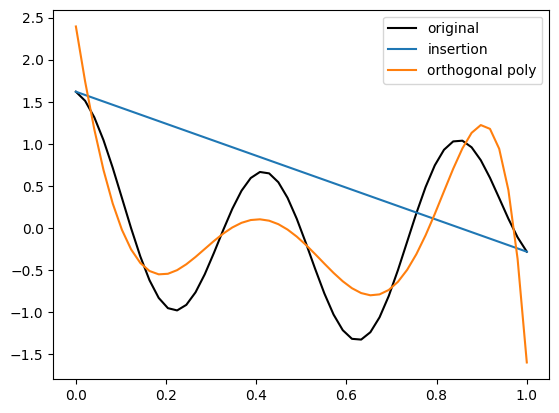

In [26]:
plt.plot(t_grid, example_path(t_grid), color='black', label='original')
plt.plot(torch.linspace(0, 1, depth+1), reconstructed_signatory[0, :, 0], label='insertion')
plt.plot(t_grid, rec, label='orthogonal poly')
plt.legend()

use time augmented path for both methods

In [27]:
# Create a path consisting in a half circle
t_grid = torch.linspace(0, 1, 100)
path = torch.stack([t_grid, example_path(t_grid)]).T.unsqueeze(0)

# Compute the signature
depth = 8
signature = signatory.signature(path, depth)

# Reconstruct the path by inverting the signature
reconstructed_signatory = signatory.invert_signature(signature, depth, path.shape[2], initial_position=path[:, 0, :])

In [29]:
# inversion via legendre
inv1 = Sig2path(pdf_l, t_grid=np.array(t_grid))
rec = inv1.path2path(np.array(t_grid), np.array(path)[0, :, 1], depth-2) + np.array(path)[0, 0, 1]

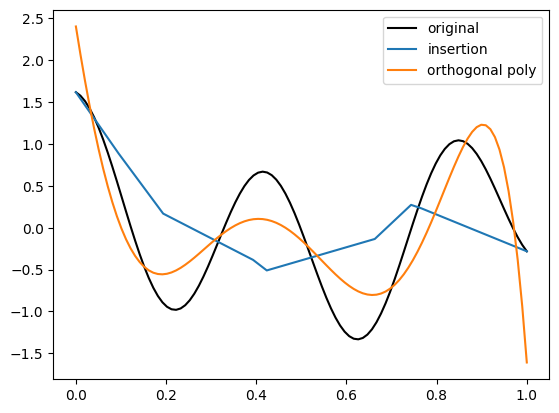

In [30]:
plt.plot(t_grid, example_path(t_grid), color='black', label='original')
plt.plot(reconstructed_signatory[0, :, 0], reconstructed_signatory[0, :, 1], label='insertion')
plt.plot(t_grid, rec, label='orthogonal poly')
plt.legend()

time-augmented path

compare reconstruction quality and time cost by changing depth and time length

 70%|███████   | 7/10 [00:05<00:03,  1.20s/it]e:\File_VSCode\M3R\M3R_LMU\ortho2sig.py:105: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(lambda t: other(t) * nppoly.polyval(t, p) *
e:\File_VSCode\M3R\M3R_LMU\ortho2sig.py:105: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(lambda t: other(t) * nppoly.polyval(t, p) *
e:\File_VSCode\M3R\M3R_LMU\ortho2sig.py:105: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(lambda t: other(t) * nppoly.polyval(t, p) *
e:\File_VSCode\M3R\M3R_LMU\ortho2sig.py:105: IntegrationWarning: The occurrence of roundoff error is detected, which 

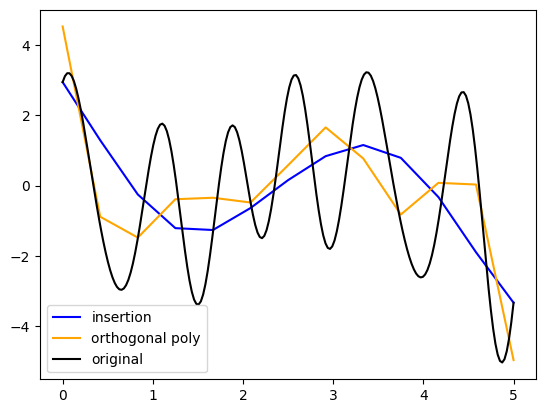

In [34]:
sample_num = 10
max_depth = 12

errors = np.zeros((2, 3, max_depth-2))
time_cost = np.zeros((2, 3, max_depth-2))

func_list = []
for _ in range(sample_num):
    func_list.append(random_trig_generator(np.random.randint(1, 10000)))

for depth in tqdm(range(3, max_depth+1)):
    for i, t_len in enumerate([0.5, 1, 5]):
        t_grid = np.linspace(0, t_len, 200)
        t = np.linspace(0, t_len, depth+1)
        for j in range(sample_num):
            func1 = func_list[j]
            path = func1(t_grid)
            path_torch = np.stack([t_grid, func1(t_grid)], axis=1)
            path_torch = torch.tensor(path_torch).unsqueeze(0)
            # insertion
            signature = signatory.signature(path_torch, depth)
            start = time.time()
            recon_insertion = signatory.invert_signature(signature, depth, path_torch.shape[2], initial_position=path_torch[:, 0, :])
            end = time.time()
            errors[0, i, depth-3] += mean_squared_error(func1(t), np.array(recon_insertion.squeeze(0))[:, 1])
            time_cost[0, i, depth-3] += end - start
            # inversion via Legendre polynomials
            inv1 = Sig2path(pdf_l, t_grid=t_grid)
            sig1 = inv1.sig(path, depth)
            start = time.time()
            rec = inv1.sig2path(t, depth-2, sig1) + path[0]
            end = time.time()
            errors[1, i, depth-3] += mean_squared_error(func1(t), rec)
            time_cost[1, i, depth-3] += end - start

errors /= sample_num
time_cost /= sample_num

# visualsation
plt.plot(t, np.array(recon_insertion.squeeze(0))[:, 1], color='blue', label='insertion')
plt.plot(t, rec, color='orange', label='orthogonal poly')
plt.plot(t_grid, path, color='black', label='original')
plt.legend()

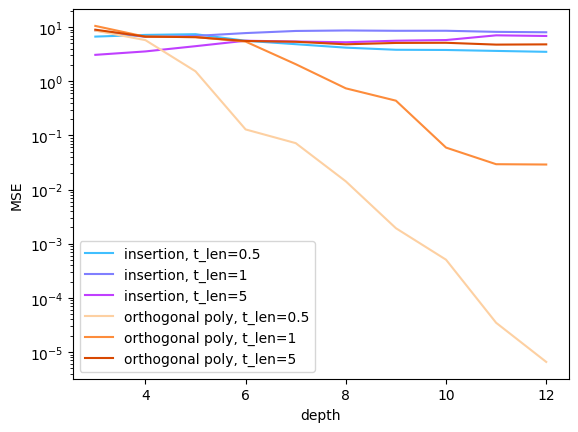

In [36]:
cmap = plt.get_cmap('cool')
c = cmap(np.linspace(0, 1, 5))
for i, t_len in enumerate([0.5, 1, 5]):
    plt.plot(range(3, max_depth+1), errors[0, i], label=f'insertion, t_len={t_len}', color=c[i+1])
cmap = plt.get_cmap('Oranges')
c = cmap(np.linspace(0, 1, 5))
for i, t_len in enumerate([0.5, 1, 5]):
    plt.plot(range(3, max_depth+1), errors[1, i], label=f'orthogonal poly, t_len={t_len}', color=c[i+1])
plt.xlabel('depth')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()

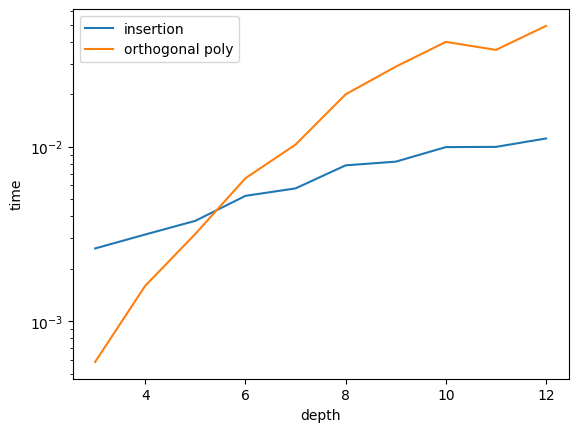

In [37]:
plt.plot(range(3, max_depth+1), time_cost[0, 0], label='insertion')
plt.plot(range(3, max_depth+1), time_cost[1, 0], label='orthogonal poly')
plt.xlabel('depth')
plt.ylabel('time')
plt.yscale('log')
plt.legend()

rough paths

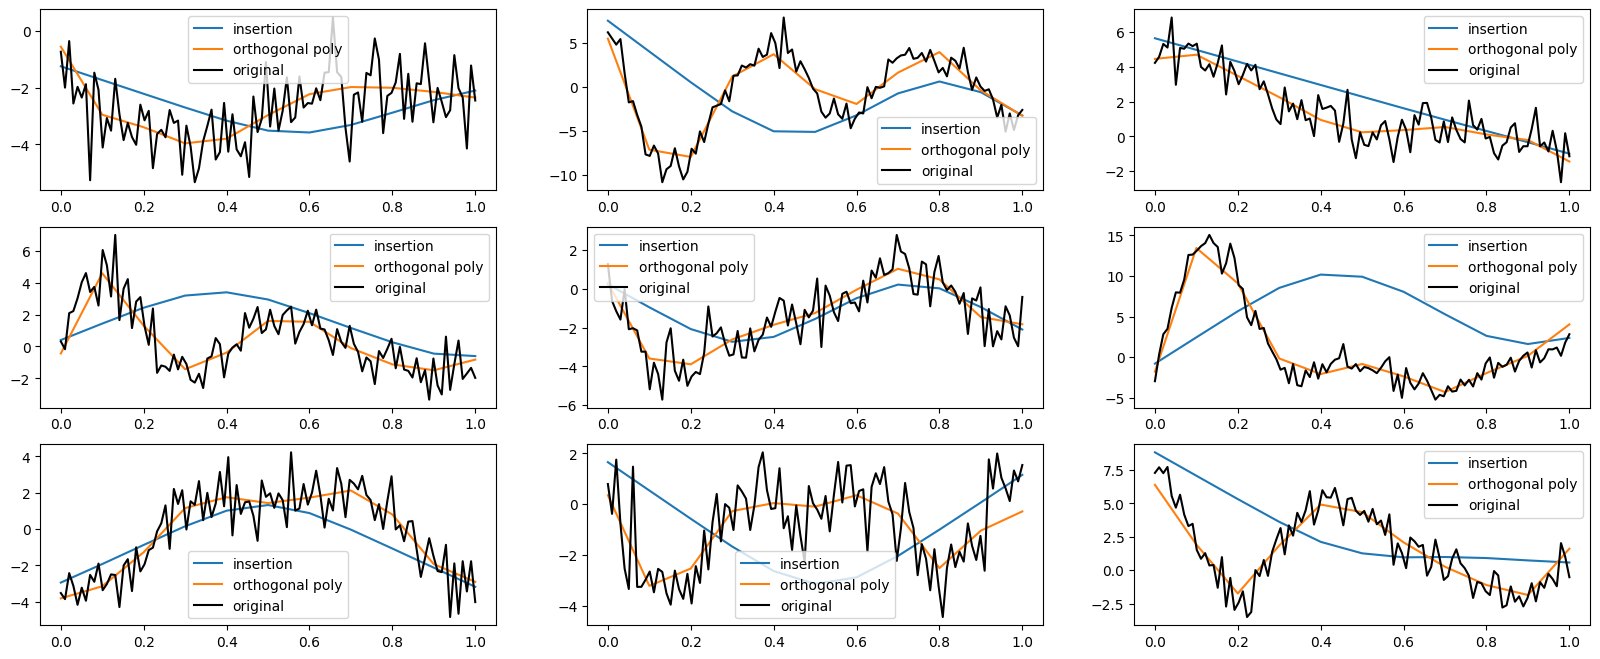

In [40]:
depth = 10
t_grid = np.linspace(0, 1, 100)
plt.figure(figsize=(20, 8))
for i in range(9):
    func1 = random_trig_generator(np.random.randint(1, 10000))
    path = func1(t_grid) + np.random.randn(len(t_grid))
    path_torch = np.stack([t_grid, func1(t_grid)], axis=1)
    path_torch = torch.tensor(path_torch).unsqueeze(0)
    # insertion
    signature = signatory.signature(path_torch, depth)
    recon_insertion = signatory.invert_signature(signature, depth, path_torch.shape[2], initial_position=path_torch[:, 0, :])
    # inversion via Legendre polynomials
    inv1 = Sig2path(pdf_l, t_grid=t_grid)
    rec = inv1.path2path(np.linspace(0, 1, depth+1), path, depth-2) + path[0]
    # visualsation
    plt.subplot(3, 3, i+1)
    plt.plot(np.linspace(0, 1, depth+1), np.array(recon_insertion.squeeze(0))[:, 1], label='insertion')
    plt.plot(np.linspace(0, 1, depth+1), rec, label='orthogonal poly')
    plt.plot(t_grid, path, color='black', label='original')
    plt.legend()

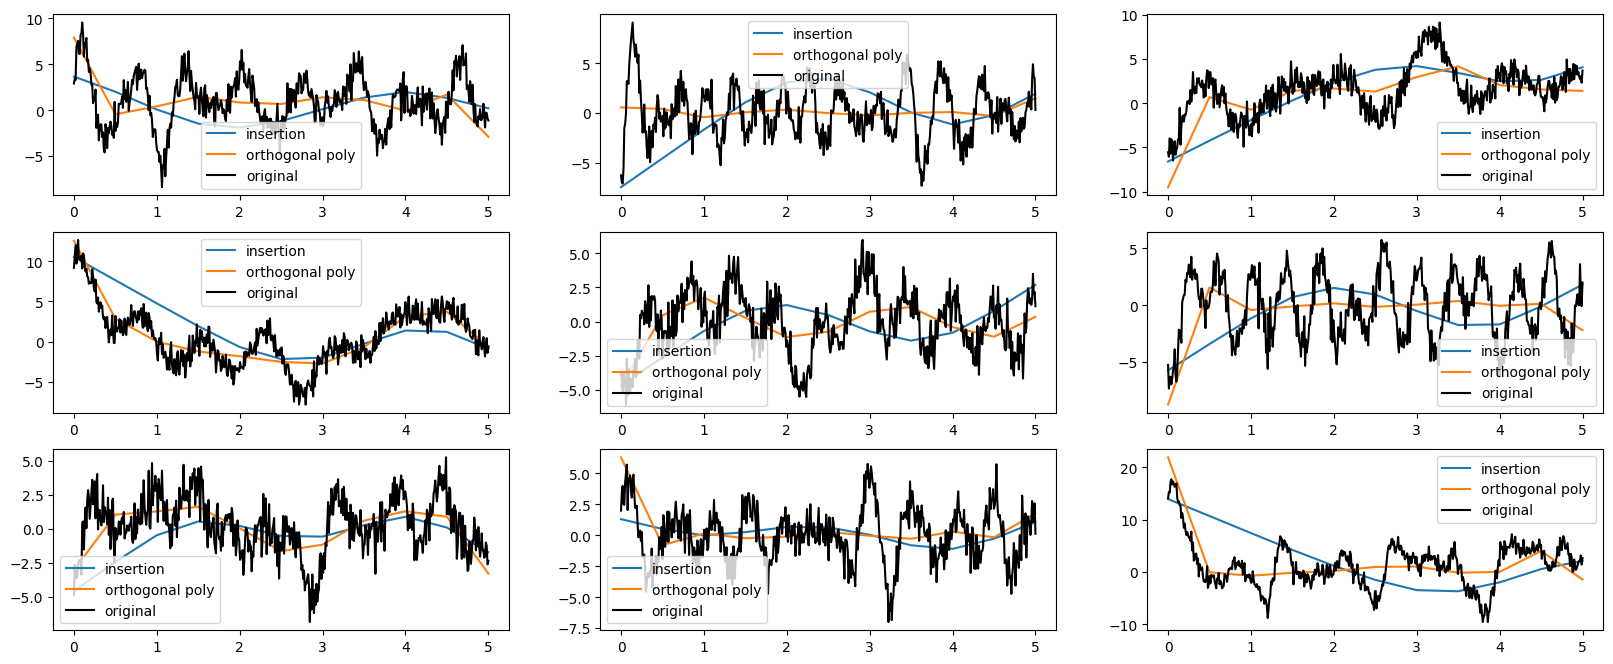

In [41]:
depth = 10
t_grid = np.linspace(0, 5, 500)
plt.figure(figsize=(20, 8))
for i in range(9):
    func1 = random_trig_generator(np.random.randint(1, 10000))
    path = func1(t_grid) + np.random.randn(len(t_grid))
    path_torch = np.stack([t_grid, func1(t_grid)], axis=1)
    path_torch = torch.tensor(path_torch).unsqueeze(0)
    # insertion
    signature = signatory.signature(path_torch, depth)
    recon_insertion = signatory.invert_signature(signature, depth, path_torch.shape[2], initial_position=path_torch[:, 0, :])
    # inversion via Legendre polynomials
    inv1 = Sig2path(pdf_l, t_grid=t_grid)
    rec = inv1.path2path(np.linspace(0, 5, depth+1), path, depth-2) + path[0]
    # visualsation
    plt.subplot(3, 3, i+1)
    plt.plot(np.linspace(0, 5, depth+1), np.array(recon_insertion.squeeze(0))[:, 1], label='insertion')
    plt.plot(np.linspace(0, 5, depth+1), rec, label='orthogonal poly')
    plt.plot(t_grid, path, color='black', label='original')
    plt.legend()